In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values+
import matplotlib.pyplot as plt
#from ECOanalysis import update_plotstyle, cmap_OB
#cmap_OB=cmap_OB(); update_plotstyle()

In [2]:
exp_prefix = ['EXP00','EXP01','EXP00_NoGM']#['EXP00','EXP00_NoGM','EXP03','EXP05',]#,'EXP03']#,'EXP01','EXP01','EXP02','EXP02']       # Import all files with this prefix
exp_suffix = ['_1d10','_1d10','_1d10']#['_1d10','_1d10','_1d10','_1d10',]#,'_1d10_NoGM_HDiff']#,'_1d10','_1d10_NoGM','_1d10','_1d10_NoGM']#,'_1d10_HDiff','_1d10_NoGM_HDiff',]
#timestep_slice = {'_6h1440':None, '_12h720':None, '_1d10':(0,360)}
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'],timestep_slice=(0,360))

In [3]:
# get base configuration of EXP00
kwargs={}
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#for exp in exp_suffix: kwargs[exp_prefix+exp] = config_parser(exp_prefix)
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml
Using processing configuration base.yml


In [4]:
for exp in ds:
    print(f'\nExperiment {exp}\n' )
    maskargs = {'mask':'usr_def','mask_values':ds[exp].mask_bd_t}

    z_v = properties[exp].global_mean(ds[exp].depth)[0].values
    z_0 = energetics[exp].center_of_gravity_classical(ds[exp].rho_gm)[0].values
    #z_s = energetics[exp].center_of_gravity_classical(ds[exp].rho)[0].values
    #z_0b = energetics[exp].center_of_gravity_classical(ds[exp].rho_gm, boussinesq=True)[0].values

    zg_stable = energetics[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, ds[exp].depth, Z_r = z_v)[0].values
    zg_mixed = energetics[exp].center_of_gravity_h(ds[exp].t_gm, ds[exp].s_gm, ds[exp].depth, Z_r = z_v)[0].values
    #zg_stable = energetics[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, ds[exp].depth, Z_r = z_0)[0].values
    #zg_0b = energetics[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, ds[exp].depth, Z_r = z_0b)[0].values

    print(f'Depth centered metric\n-------------------------------')
    print(f'z_v: {z_v}')   #         |   zgb(z_v): {zg_v}')
    print(f'zg_stable: {zg_stable}   |   zg_mixed: {zg_mixed}')
    #print(f'z_gs: {z_s}           ')# |   zgb(z_v): {zg_v}')
    #print(f'z_g0b(<rho>): {z_0b}   |   zgb(z_g0b): {zg_0b}')


Experiment EXP00_1d10

Depth centered metric
-------------------------------
z_v: -1997.0726090029812
zg_stable: -0.3703150304999438   |   zg_mixed: -0.10668978815150082

Experiment EXP00_1d10_NoGM

Depth centered metric
-------------------------------
z_v: -1997.0726089010768
zg_stable: -0.37031467860780676   |   zg_mixed: -0.10668978791245881

Experiment EXP01_1d10

Depth centered metric
-------------------------------
z_v: -1997.072607783486
zg_stable: -0.3421040617468746   |   zg_mixed: -0.10451013655930613

Experiment EXP01_1d10_NoGM

Depth centered metric
-------------------------------
z_v: -1997.0726071788056
zg_stable: -0.34210390495922566   |   zg_mixed: -0.10451013636220767


In [14]:
def props(exp, mode='full'):
    g = properties[exp].constants['g']
    rho0 = properties[exp].constants['rho0']

    a0 = properties[exp].eos_properties['thermal_expansion']
    b0 = properties[exp].eos_properties['haline_expansion']
    l1 = properties[exp].eos_properties['cabbeling_T']
    l2 = properties[exp].eos_properties['cabbeling_S']
    nu = properties[exp].eos_properties['cabbeling_TS']
    mu1 = properties[exp].eos_properties['thermobaric_T']
    mu2 = properties[exp].eos_properties['thermobaric_S']

    
    if mode=='gm':
        maskargs= {'mask':'usr_def','mask_values':ds[exp].mask_bd_t}
        dT = properties[exp].global_mean(ds[exp].to,**maskargs) - 10
        dS = properties[exp].global_mean(ds[exp].so,**maskargs) - 35
        Zr = ds[exp].zg_0
        Z = ds[exp].depth_1d
        mask = properties[exp].horizontal_mean(ds[exp].mask_bd_t)[:,0]
    elif mode=='full':
        dT = ds[exp].to - 10
        dS = ds[exp].so - 35
        Zr = ds[exp].zg_0
        Z = ds[exp].depth
        mask = ds[exp].mask_bd_t

    def b(dT, dS, Z):
        return - g/rho0 * ( - a0 * (1+l1/2*dT+mu1*(Z)) * dT + b0 * (1 - l2/2*dS - mu2*(Z)) * dS - nu*dT*dS) 
        

    def h(dT, dS, Z, Zr):
        h = - g/rho0 * ((-a0 * (1+l1/2*dT) * dT + b0 * (1-l2/2*dS) * dS - nu*dT*dS) * (Zr - Z)
                + 0.5 * (-a0*mu1*dT + b0*mu2*dS) * (Zr**2 - Z**2))
        return h

    def h_new(dT, dS, Z, Zr=0):

        h = - b(dT, dS, Z-Zr)*(Z-Zr) + g/rho0*a0*mu1/2*dT*(Z-Zr)**2
        return h
    
    def h_new_sep(dT, dS, Z):
        b_h = b(dT, dS, Z)*Z
        C = g/rho0*a0*mu1/2*dT*Z**2
        h  = xr.zeros_like(b_h)
        for z in ds[exp0].z_c:
            if (ds[exp0].depth_1d[z]-ds[exp0].zg_0[0])<0:
                h[:,z] = - b_h[:,z] - C[:,z]
            else:
                h[:,z] = - b_h[:,z] + C[:,z]
        return h
    
    def h_new_sep1(dT, dS, Z):
        
        hp =  g/rho0 * ((-a0 * (1+l1/2*dT) * dT + b0 * (1-l2/2*dS) * dS - nu*dT*dS) * (Z)
                + 0.5 * (-a0*mu1*dT + b0*mu2*dS) * (Z**2))
        hn =  g/rho0 * ((-a0 * (1+l1/2*dT) * dT + b0 * (1-l2/2*dS) * dS - nu*dT*dS) * (Z)
                - 0.5 * (-a0*mu1*dT + b0*mu2*dS) * (Z**2))
        h  = xr.zeros_like(hp)
        for z in ds[exp0].z_c:
            if (ds[exp0].depth_1d[z]-ds[exp0].zg_0[0])<0:
                h[:,z] = hp[:,z]
            else:
                h[:,z] = hn[:,z]
        return h
    
    return b(dT, dS, Z)*mask, h(dT, dS, Z, Zr)*mask, b(dT, dS, Z)*mask, h_new(dT, dS, Z, Zr=Zr)*mask#, h_new_sep(dT, dS, Z-Zr)*mask, h_new_sep1(dT, dS, Z-Zr)*mask

def h(exp, T, S, Z):
    Zr = properties[exp].global_mean(Z)
    print(Zr.mean('t').values)
    g = properties[exp].constants['g']
    rho0 = properties[exp].constants['rho0']

    a0 = properties[exp].eos_properties['thermal_expansion']
    b0 = properties[exp].eos_properties['haline_expansion']
    l1 = properties[exp].eos_properties['cabbeling_T']
    l2 = properties[exp].eos_properties['cabbeling_S']
    nu = properties[exp].eos_properties['cabbeling_TS']
    mu1 = properties[exp].eos_properties['thermobaric_T']
    mu2 = properties[exp].eos_properties['thermobaric_S']
    dT = T-10
    dS = S-35

    h = - g/rho0 * ((-a0 * (1+l1/2*dT) * dT + b0 * (1-l2/2*dS) * dS - nu*dT*dS) * (Zr - Z)
            + 0.5 * (-a0*mu1*dT + b0*mu2*dS) * (Zr**2 - Z**2))
    return h

In [5]:
bh={}
for exp in ds:
    bh[exp] = props(exp, mode='full')
    bh[exp+'_gm'] = props(exp, mode='gm')

In [15]:
h1 = h('EXP00_1d10', ds['EXP00_1d10'].to[:,:10], ds['EXP00_1d10'].so[:,:10], ds['EXP00_1d10'].depth[:,:10])
h2 = h('EXP00_1d10', ds['EXP00_1d10'].to[:,10:], ds['EXP00_1d10'].so[:,10:], ds['EXP00_1d10'].depth[:,10:])

-57.36714687177025
-2054.4597112055003


In [11]:
h1_gm=properties['EXP00_1d10'].global_mean(h1)
h2_gm=properties['EXP00_1d10'].global_mean(h2)

In [13]:
h2_gm.mean('t').values

array(-2.68114565)

In [12]:
h1_gm.mean('t').values

array(-0.04688268)

In [124]:
def h_new_c(exp, mode='full'):
    g = properties[exp].constants['g']
    rho0 = properties[exp].constants['rho0']

    a0 = properties[exp].eos_properties['thermal_expansion']
    b0 = properties[exp].eos_properties['haline_expansion']
    l1 = properties[exp].eos_properties['cabbeling_T']
    l2 = properties[exp].eos_properties['cabbeling_S']
    nu = properties[exp].eos_properties['cabbeling_TS']
    mu1 = properties[exp].eos_properties['thermobaric_T']
    mu2 = properties[exp].eos_properties['thermobaric_S']

    if mode=='gm':
        maskargs= {'mask':'usr_def','mask_values':ds[exp].mask_bd_t}
        dT = properties[exp].global_mean(ds[exp].to,**maskargs) - 10
        dS = properties[exp].global_mean(ds[exp].so,**maskargs) - 35
        Zr = ds[exp].zg_0
        Z = ds[exp].depth_1d
        mask = properties[exp].horizontal_mean(ds[exp].mask_bd_t)[:,0]
    elif mode=='full':
        dT = ds[exp].to - 10
        dS = ds[exp].so - 35
        Zr = ds[exp].zg_0
        Z = ds[exp].depth
        mask = ds[exp].mask_bd_t

    def bl(dT, dS, Z):
        return - g/rho0 * ( - a0 * (1) * dT + b0 * (1) * dS) 
    def bc(dT, dS, Z):
        return - g/rho0 * ( - a0 * (l1/2*dT) * dT + b0 * (-l2/2*dS) * dS - nu*dT*dS) 
    def bt(dT, dS, Z):
        return - g/rho0 * ( - a0 * (mu1*(Z)) * dT + b0 * (-mu2*(Z)) * dS) 
    def corr(dT, Z):
        return g/rho0*a0*mu1/2*dT*(Z)**2
    #h = - b(dT, dS, Z-Zr)*(Z-Zr) - g/rho0*a0*mu1/2*dT*(Z-Zr)**2
    return - bl(dT, dS, Z)*(Z-Zr), - bc(dT, dS, Z)*(Z-Zr), - bt(dT, dS, Z-Zr)*(Z) , corr(dT, Z-Zr)
    

In [127]:
bl, bc, bt, corr = h_new_c(exp0)
bl_gm, bc_gm, bt_gm, corr_gm = h_new_c(exp0, mode='gm')


In [126]:
print(1/9.81*properties[exp0].global_mean((bl)).mean('t').compute().values)
print(1/9.81*properties[exp0].global_mean((bc)).mean('t').compute().values)
print(1/9.81*properties[exp0].global_mean((bt)).mean('t').compute().values)
print(1/9.81*properties[exp0].global_mean((corr)).mean('t').compute().values)
print(1/9.81*properties[exp0].global_mean(bl+bc+bt+corr).mean('t').compute().values)

-0.2419858957505606
0.05341806196337148
-0.16886159655702124
0.08443079810714317
-0.2729986311476263


In [130]:
print(1/9.81*grid_ops[exp].average((bl_gm),'Z').mean('t').compute().values)
print(1/9.81*grid_ops[exp].average((bc_gm),'Z').mean('t').compute().values)
print(1/9.81*grid_ops[exp].average((bt_gm),'Z').mean('t').compute().values)
print(1/9.81*grid_ops[exp].average((corr_gm),'Z').mean('t').compute().values)
print(1/9.81*grid_ops[exp].average(bl_gm+bc_gm+bt_gm+corr_gm,'Z').mean('t').compute().values)

6.896583823635487e-05
-8.13199134912026e-06
-0.21348822045627724
0.10674411022813866
-0.10668327638125139


In [6]:
zg = {exp:{} for exp in ds}
for exp in ds:
    zg[exp]['zg_h'] = 1/9.81*properties[exp].global_mean(bh[exp][1]).compute()
    zg[exp]['zg_h_gm'] = 1/9.81*grid_ops[exp].average(bh[exp+'_gm'][1],'Z').compute()
    zg[exp]['zg_h_new'] = 1/9.81*properties[exp].global_mean(bh[exp][3]).compute()
    zg[exp]['zg_h_gm_new'] = 1/9.81*grid_ops[exp].average(bh[exp+'_gm'][3],'Z').compute()
    # zg[exp]['zg_h_new_sep'] = 1/9.81*properties[exp].global_mean(bh[exp][4]).compute()
    # zg[exp]['zg_h_gm_new_sep'] = 1/9.81*grid_ops[exp].average(bh[exp+'_gm'][4],'Z').compute()
    # zg[exp]['zg_h_new_sep1'] = 1/9.81*properties[exp].global_mean(bh[exp][5]).compute()
    # zg[exp]['zg_h_gm_new_sep1'] = 1/9.81*grid_ops[exp].average(bh[exp+'_gm'][5],'Z').compute()

In [8]:
for exp in ds:
    print((zg[exp]['zg_h']-zg[exp]['zg_h_gm']).mean('t').values)
    print((zg[exp]['zg_h_new']).mean('t').values)

-0.2636297679094207
-0.27229300291354136
-0.2378556416558824
-0.2589103145013173
-0.26496238176824716
-0.2728893417629966


In [7]:
for exp in ds:
    print(f'\n{exp}\n---------------')
    for z in zg[exp]:
        print(z, zg[exp][z].mean('t').values)


EXP00_1d10
---------------
zg_h -0.37025643810323505
zg_h_gm -0.10662667019381437
zg_h_new -0.27229300291354136
zg_h_gm_new -0.10663888462521569

EXP01_1d10
---------------
zg_h -0.34229509190688656
zg_h_gm -0.10443945025100412
zg_h_new -0.2589103145013173
zg_h_gm_new -0.10445027823799313

EXP00_NoGM_1d10
---------------
zg_h -0.3708714653735241
zg_h_gm -0.1059090836052769
zg_h_new -0.2728893417629966
zg_h_gm_new -0.10592123944857931


In [4]:
sumt = {}
for exp in ds:
    sumt[exp] = 0
    keys = []
    Zeros = xr.zeros_like(ds[exp].e3tm)
    Zeros[:,0] +=  1
    for var in ds[exp]:
        if 'tt' in var:
            if 'tot' in var or 'ad' in var or 'atf' in var:
                continue
            keys.append(var[5:])
            if ds[exp][var].dims == ('t','y_c','x_c'):
                p_3d = ds[exp][var].expand_dims({'z_c':ds[exp].z_c},axis=1) * Zeros
                p = properties[exp].global_mean(p_3d, Vmask=ds[exp].mask_bd_t)#[0].values
            else:
                p = properties[exp].global_mean(ds[exp][var], Vmask=ds[exp].mask_bd_t)#[0].values
            print(p.mean('t').values)
            sumt[exp] += p
            #print(var, p.mean('t').values)
            #p.plot()
    print(exp, ' SUM: ', sumt[exp].mean('t').values, keys)

-1.0560396609252217e-20
-6.363911629056445e-20
-1.0976971050675778e-08
1.0969915852084264e-08
EXP00_1d10  SUM:  -7.055198665713538e-12 ['ldf', 'zdf', 'qns', 'qsr']
-2.4456602854905943e-19
4.0144513543502197e-19
-1.0905407179469556e-08
1.0969915851547116e-08
EXP00_1d10_HDiff  SUM:  6.450867223443928e-11 ['ldf', 'zdf', 'qns', 'qsr']
-5.013464048318562e-20
-1.3847095046341843e-19
-1.0966755202733636e-08
1.0969915852064999e-08
EXP00_1d10_NoGM  SUM:  3.1606491427592028e-12 ['ldf', 'zdf', 'qns', 'qsr']
1.8430688503204365e-19
-7.099472288347122e-20
-1.0988295376339874e-08
1.0969915853301925e-08
EXP00_NoGM_1d10  SUM:  -1.8379522924635285e-11 ['ldf', 'zdf', 'qns', 'qsr']


In [8]:
sumt_new = {}
for exp in ds:
    sumt_new[exp] = ds[exp]['ttrd_tot']*0
    keys = []
    Zeros = xr.zeros_like(ds[exp].e3tm)
    Zeros[:,0] +=  1
    s = 0
    for var in ds[exp]:
        if 'tt' in var:
            if 'tot' in var or 'atf' in var:
                continue
            keys.append(var[5:])
            if ds[exp][var].dims == ('t','y_c','x_c'):
                p3d = ds[exp][var].expand_dims({'z_c':ds[exp].z_c},axis=1) * Zeros * ds[exp].mask_bd_t
                s = s + p3d
            else:
                s += ds[exp][var]
    sumt_new[exp] = properties[exp].global_mean(s, Vmask=ds[exp].mask_bd_t)
    print(exp, ' SUM: ', sumt_new[exp].mean('t').values, keys)

EXP00_1d10  SUM:  -7.054087629246043e-12 ['xad', 'yad', 'zad', 'ldf', 'zdf', 'qns', 'qsr']
EXP00_1d10_HDiff  SUM:  6.451091904939581e-11 ['xad', 'yad', 'zad', 'ldf', 'zdf', 'qns', 'qsr']
EXP00_1d10_NoGM  SUM:  3.1667164903554207e-12 ['xad', 'yad', 'zad', 'ldf', 'zdf', 'qns', 'qsr']
EXP00_NoGM_1d10  SUM:  -1.838187947665788e-11 ['xad', 'yad', 'zad', 'ldf', 'zdf', 'qns', 'qsr']


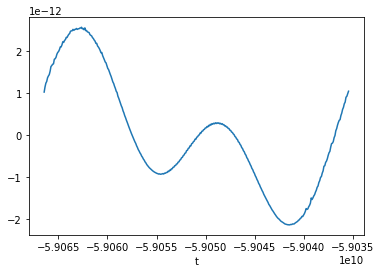

In [9]:
for i, exp in enumerate(ds):
    if i!=0: continue
    (sumt_new[exp]-properties[exp].global_mean(ds[exp].ttrd_tot, Vmask=ds[exp].mask_bd_t)).plot()
    #
    # properties[exp].global_mean(sumt[exp]-ds[exp].ttrd_tot-tot_ad_t[exp], Vmask=ds[exp].mask_bd_t).plot(linestyle='--')

In [55]:
sums = {}
for exp in ds:
    sums[exp] = 0
    keys = []
    Zeros = xr.zeros_like(ds[exp].e3tm)
    Zeros[:,0] +=  1
    for var in ds[exp]:
        if 'st' in var:
            if 'tot' in var or 'ad' in var or 'atf' in var:
                continue
            keys.append(var[5:])
            if ds[exp][var].dims == ('t','y_c','x_c'):
                p_3d = ds[exp][var].expand_dims({'z_c':ds[exp].z_c},axis=1) * Zeros
                p = properties[exp].global_mean(p_3d, Vmask=ds[exp].mask_bd_t)#[0].values
            else:
                p = properties[exp].global_mean(ds[exp][var], Vmask=ds[exp].mask_bd_t)#[0].values
            sums[exp] += p
            #print(var, p.mean('t').values)
            #p.plot()
    print(exp, ' SUM: ', sums[exp].mean('t').values, keys)

EXP00_1d10  SUM:  -2.490488148408642e-13 ['ldf', 'zdf', 'cdt']
EXP00_1d10_HDiff  SUM:  1.837483777718958e-12 ['ldf', 'zdf', 'cdt']
EXP00_1d10_NoGM  SUM:  -5.916633910120688e-14 ['ldf', 'zdf', 'cdt']
EXP00_NoGM_1d10  SUM:  -9.004749919275213e-13 ['ldf', 'zdf', 'cdt']


In [14]:
print('T - trend')
for exp in ds:
    print(exp, properties[exp].global_mean(sumt[exp]-(ds[exp].ttrd_tot), Vmask=ds[exp].mask_bd_t).mean('t').values)
    #print(exp, properties[exp].global_mean(sumt[exp]-(ds[exp].ttrd_tot+sumt_ad[exp]), Vmask=ds[exp].mask_bd_t).mean('t').values)
print('\nS - trend')
for exp in ds:
    print(exp, properties[exp].global_mean(sums[exp]-(ds[exp].strd_tot), Vmask=ds[exp].mask_bd_t).mean('t').values)

T - trend
EXP00_1d10 5.562759888428245e-16
EXP00_1d10_HDiff -3.331731159971597e-14
EXP00_1d10_NoGM 1.506182333315875e-15
EXP00_NoGM_1d10 -6.200222498673775e-15

S - trend
EXP00_1d10 -6.8061398201028474e-12
EXP00_1d10_HDiff 6.266975853674039e-11
EXP00_1d10_NoGM 3.219786159606505e-12
EXP00_NoGM_1d10 -1.7479244283388143e-11


In [41]:
tot_ad_t={exp: properties[exp].global_mean(ds[exp].ttrd_xad+ds[exp].ttrd_yad+ds[exp].ttrd_zad, Vmask=ds[exp].mask_bd_t).compute() for exp in ds}
tot_ad_s={exp: properties[exp].global_mean(ds[exp].strd_xad+ds[exp].strd_yad+ds[exp].strd_zad, Vmask=ds[exp].mask_bd_t).compute() for exp in ds}

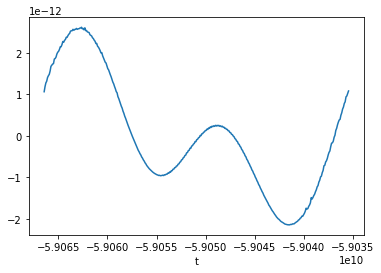

In [58]:
for i, exp in enumerate(ds):
    if i!=0: continue
    (sumt[exp]-properties[exp].global_mean(ds[exp].ttrd_tot, Vmask=ds[exp].mask_bd_t)).plot()
    #
    # properties[exp].global_mean(sumt[exp]-ds[exp].ttrd_tot-tot_ad_t[exp], Vmask=ds[exp].mask_bd_t).plot(linestyle='--')

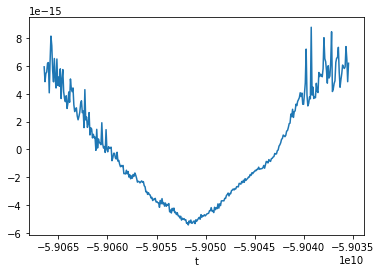

In [56]:
for i, exp in enumerate(ds):
    if i!=0: continue
    (sums[exp]-properties[exp].global_mean(ds[exp].strd_tot, Vmask=ds[exp].mask_bd_t)).plot()

In [7]:
Sumt = {}
for exp in ds:
    Sumt[exp] = 0
    keys = []
    Zeros = xr.zeros_like(ds[exp].e3tm)
    Zeros[:,0] +=  1
    for var in ds[exp]:
        if 'dzg_T' in var:
            if 'tot' in var or 'ad' in var:
                continue
            keys.append(var[5:])
            if ds[exp][var].dims == ('t','y_c','x_c'):
                p_3d = ds[exp][var].expand_dims({'z_c':ds[exp].z_c},axis=1) * Zeros
                p = properties[exp].global_mean(p_3d, Vmask=ds[exp].mask_bd_t)#[0].values
            else:
                p = properties[exp].global_mean(ds[exp][var], Vmask=ds[exp].mask_bd_t)#[0].values
            Sumt[exp] += p
            #print(var, p.mean('t').values)
            #p.plot()
    print(exp, ' SUM: ', Sumt[exp].mean('t').values, keys)

EXP00_1d10  SUM:  -3.3364381162414045e-12 ['ldf', 'zdf', 'qns', 'qsr', 'atf']
EXP00_1d10_HDiff  SUM:  -1.0997363385041431e-11 ['ldf', 'zdf', 'qns', 'qsr', 'atf']
EXP00_1d10_NoGM  SUM:  6.424138411505648e-12 ['ldf', 'zdf', 'qns', 'qsr', 'atf']
EXP00_NoGM_1d10  SUM:  6.9675505648615405e-12 ['ldf', 'zdf', 'qns', 'qsr', 'atf']


In [9]:
Sums = {}
for exp in ds:
    Sums[exp] = 0
    keys = []
    Zeros = xr.zeros_like(ds[exp].e3tm)
    Zeros[:,0] +=  1
    for var in ds[exp]:
        if 'dzg_S' in var:
            if 'tot' in var or 'ad' in var or 'ness' in var:
                continue
            keys.append(var[5:])
            if ds[exp][var].dims == ('t','y_c','x_c'):
                p_3d = ds[exp][var].expand_dims({'z_c':ds[exp].z_c},axis=1) * Zeros
                p = properties[exp].global_mean(p_3d, Vmask=ds[exp].mask_bd_t)#[0].values
            else:
                p = properties[exp].global_mean(ds[exp][var], Vmask=ds[exp].mask_bd_t)#[0].values
            Sums[exp] += p
            #print(var, p.mean('t').values)
            #p.plot()
    print(exp, ' SUM: ', Sums[exp].mean('t').values, keys)

EXP00_1d10  SUM:  1.1067284842104613e-11 ['ldf', 'zdf', 'cdt', 'atf']
EXP00_1d10_HDiff  SUM:  8.50221354549912e-12 ['ldf', 'zdf', 'cdt', 'atf']
EXP00_1d10_NoGM  SUM:  7.211604747414686e-12 ['ldf', 'zdf', 'cdt', 'atf']
EXP00_NoGM_1d10  SUM:  8.368873825937982e-12 ['ldf', 'zdf', 'cdt', 'atf']


In [11]:
dh_T = {exp: properties[exp].dh_T(ds[exp].to_s, ds[exp].so_s, ds[exp].depth, Z_r=ds[exp].zg_0) for exp in ds}
dh_S = {exp: properties[exp].dh_S(ds[exp].to_s, ds[exp].so_s, ds[exp].depth, Z_r=ds[exp].zg_0) for exp in ds}

dzg_Ttot = {exp: 1/9.81*dh_T[exp]*ds[exp].ttrd_tot for exp in ds}
dzg_Stot = {exp: 1/9.81*dh_S[exp]*ds[exp].strd_tot for exp in ds}

In [15]:
print('zgT - trend')
for exp in ds:
    print(exp, properties[exp].global_mean(Sumt[exp]-(dzg_Ttot[exp]), Vmask=ds[exp].mask_bd_t).mean('t').values)
    #print(exp, properties[exp].global_mean(sumt[exp]-(ds[exp].ttrd_tot+sumt_ad[exp]), Vmask=ds[exp].mask_bd_t).mean('t').values)
print('\nzgS - trend')
for exp in ds:
    print(exp, properties[exp].global_mean(Sums[exp]-(dzg_Ttot[exp]), Vmask=ds[exp].mask_bd_t).mean('t').values)

zgT - trend
EXP00_1d10 -4.459198068529742e-12
EXP00_1d10_HDiff -3.684622748472302e-12
EXP00_1d10_NoGM 1.978238023018304e-12
EXP00_NoGM_1d10 2.822205195027796e-12

zgS - trend
EXP00_1d10 9.944524889816293e-12
EXP00_1d10_HDiff 1.5814954182068232e-11
EXP00_1d10_NoGM 2.7657043589273414e-12
EXP00_NoGM_1d10 4.2235284561042575e-12


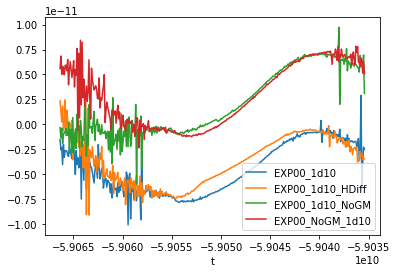

In [18]:
for exp in ds:
    (Sumt[exp]-properties[exp].global_mean(dzg_Ttot[exp], Vmask=ds[exp].mask_bd_t)).plot(label=exp)
plt.legend()

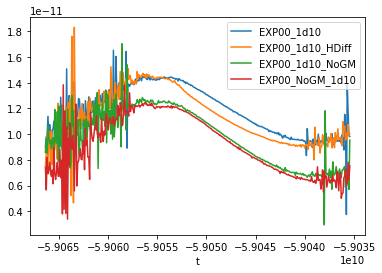

In [19]:
for exp in ds:
    (Sums[exp]-properties[exp].global_mean(dzg_Stot[exp], Vmask=ds[exp].mask_bd_t)).plot(label=exp)
plt.legend()

In [4]:
maskargs_t={exp: {'mask':'usr_def','mask_values':ds[exp].mask_bd_t} for exp in ds}
maskargs_w={exp: {'mask':'usr_def','mask_values':ds[exp].mask_bd_w} for exp in ds}
rhos = {exp: properties[exp].density(ds[exp].tos,ds[exp].sos,0)  for exp in ds if 'tos' in ds[exp]}

In [5]:
drho_W ={exp: (grid_ops[exp]._shift_position((ds[exp].rho_s-1026),'W',
                maskargs=maskargs_w[exp])).compute() for exp in ds}
drho_W_replace ={exp: (grid_ops[exp]._shift_position((ds[exp].rho_s-1026),'W',
                maskargs=maskargs_w[exp])).compute() for exp in ds}
drho_W_replace_s ={exp: (grid_ops[exp]._shift_position((ds[exp].rho_s-1026),'W',
                maskargs=maskargs_w[exp])).compute() for exp in ds if exp in rhos}

for exp in drho_W:
    for i in range(len(ds[exp].t)):
        drho_W_replace[exp][i,0] = ds[exp].rho_s[i,0].values-1026
        if exp in rhos:
            drho_W_replace_s[exp][i,0] = rhos[exp][i].values-1026


In [6]:
C_h={}
C_h_replace = {}
C_h_replace_s = {}

for exp in drho_W:

    z_conv_h=(1/1026*drho_W[exp]*ds[exp].wo*ds[exp].e3wm) 
    C_h[exp] = (grid_ops[exp]._shift_position(z_conv_h,'T',
                maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() 
    
    z_conv_h=(1/1026*drho_W_replace[exp]*ds[exp].wo*ds[exp].e3wm) 
    C_h_replace[exp] = (grid_ops[exp]._shift_position(z_conv_h,'T',
                maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() 
    
    if exp in rhos:
        z_conv_h=(1/1026*drho_W_replace_s[exp]*ds[exp].wo*ds[exp].e3wm) 
        C_h_replace_s[exp] = (grid_ops[exp]._shift_position(z_conv_h,'T',
                    maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() 

In [7]:
Ce_h={}
Ce_h_replace = {}
Ce_h_replace_s = {}

for exp in drho_W:

    z_conv_h=(1/1026*drho_W[exp]*ds[exp].wo_e*ds[exp].e3wm) 
    Ce_h[exp] = (grid_ops[exp]._shift_position(z_conv_h,'T',
                maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() 
    
    z_conv_h=(1/1026*drho_W_replace[exp]*ds[exp].wo_e*ds[exp].e3wm) 
    Ce_h_replace[exp] = (grid_ops[exp]._shift_position(z_conv_h,'T',
                maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() 
    
    if exp in rhos:
        z_conv_h=(1/1026*drho_W_replace_s[exp]*ds[exp].wo_e*ds[exp].e3wm) 
        Ce_h_replace_s[exp] = (grid_ops[exp]._shift_position(z_conv_h,'T',
                    maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() 

In [8]:
C_h_m = {exp: properties[exp].global_mean(C_h[exp], Vmask=ds[exp].mask_bd_t).compute() for exp in ds}
C_h_replace_m = {exp: properties[exp].global_mean(C_h_replace[exp], Vmask=ds[exp].mask_bd_t).compute() for exp in ds if exp in C_h_replace}
Ce_h_m = {exp: properties[exp].global_mean(Ce_h[exp], Vmask=ds[exp].mask_bd_t).compute() for exp in ds}

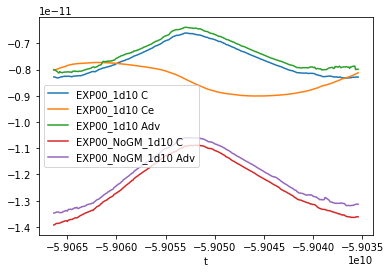

In [29]:
for i, exp in enumerate(ds):
    if i!=0 and i!=3: continue
    (C_h_m[exp]).plot(label=exp+' C')
    if i!=3: 
        #(C_h_m[exp]+Ce_h_m[exp]).plot(label=exp+' C-Ce')
        (Ce_h_m[exp]).plot(label=exp+' Ce')
    (Sum_ad[exp]).plot(label=exp+' Adv')
plt.legend()

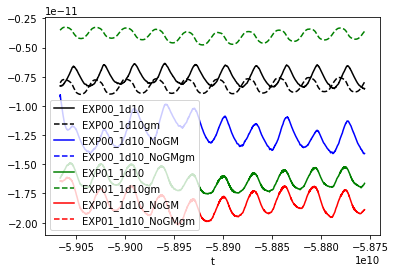

In [8]:
#properties[exp0].global_mean(C_star_h[exp0], Vmask=ds[exp0].mask_bd_t).plot()

#properties[exp0].global_mean(Cgm_star_h[exp0], Vmask=ds[exp0].mask_bd_t).plot()
c=['k','b','g','r']
for i, exp in enumerate(ds):
    properties[exp].global_mean(C_h[exp], Vmask=ds[exp].mask_bd_t).plot(label=exp, c=c[i])
    properties[exp].global_mean(Cgm_h[exp], Vmask=ds[exp].mask_bd_t).plot(label=exp+'gm', c=c[i], linestyle='--')

plt.legend()

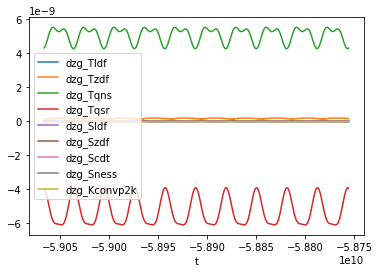

In [14]:
for var in ds[exp0]:
    if 'dzg' in var:
        if 'tot' in var or 'ad' in var:
            continue
        properties[exp0].global_mean(ds[exp0][var], Vmask=ds[exp0].mask_bd_t).plot(label=var)
plt.legend()

In [ ]:
def dzg_new(exp):
    
    dh_T = properties[exp].dh_T_new(ds[exp].to_s, ds[exp].so_s, ds[exp].depth-ds[exp].zg_0)
    dh_S = properties[exp].dh_S_new(ds[exp].to_s, ds[exp].so_s, ds[exp].depth-ds[exp].zg_0)

    dzg = {'T':{}, 'S':{}}
    for var in ds[exp]:
        if 'ttrd' in var:
            if ds[exp][var].dims == ('t','y_c','x_c'):
                p = xr.zeros_like(ds[exp].e3tm)
                p[:,0] += ds[exp][var]
                dzg['T'][var] = (dh_T*p).compute()
            else:
                dzg['T'][var] = (dh_T*ds[exp][var]).compute()
        elif 'strd' in var:
            if ds[exp][var].dims == ('t','y_c','x_c'):
                p = xr.zeros_like(ds[exp].e3tm)
                p[:,0] += ds[exp][var]
                dzg['S'][var] = (dh_S*p).compute()
            else:
                dzg['S'][var] = (dh_S*ds[exp][var]).compute()  
        else:
            continue
        print(f'{exp} - {var} - OK')
    return dzg

In [10]:
dzg={}
for exp in ds:
    dzg[exp] = dzg_new(exp)

EXP00_l_1d10 - ttrd_ldf - OK
EXP00_l_1d10 - ttrd_zdf - OK
EXP00_l_1d10 - ttrd_qns - OK
EXP00_l_1d10 - ttrd_qsr - OK
EXP00_l_1d10 - strd_ldf - OK
EXP00_l_1d10 - strd_zdf - OK
EXP00_l_1d10 - strd_cdt - OK
EXP00_l_1d10_NoGM - ttrd_ldf - OK
EXP00_l_1d10_NoGM - ttrd_zdf - OK
EXP00_l_1d10_NoGM - ttrd_qns - OK
EXP00_l_1d10_NoGM - ttrd_qsr - OK
EXP00_l_1d10_NoGM - strd_ldf - OK
EXP00_l_1d10_NoGM - strd_zdf - OK
EXP00_l_1d10_NoGM - strd_cdt - OK


In [11]:
dzg_gm = {exp:{} for exp in ds}
for exp in ds:
    print(f'{exp}:\n-------------')
    for var in dzg[exp]['T']:
        dzg_gm[exp][var]=properties[exp].global_mean(dzg[exp]['T'][var], Vmask=ds[exp].mask_bd_t).compute()
        print(var, dzg_gm[exp][var].mean('t').values)
    for var in dzg[exp]['S']:
        dzg_gm[exp][var]=properties[exp].global_mean(dzg[exp]['S'][var], Vmask=ds[exp].mask_bd_t).compute()
        print(var, dzg_gm[exp][var].mean('t').values)

EXP00_l_1d10:
-------------
ttrd_ldf -2.910058660235219e-10
ttrd_zdf 2.1004331359116e-10
ttrd_qns 3.45412258373402e-08


KeyboardInterrupt: 

In [9]:
Sum = {exp:0 for exp in ds}
for exp in ds:
    for var in ds[exp]:
        if 'dzg' in var:
            if 'tot' in var or 'ad' in var or 'conv' in var or 'ness' in var:
                continue
            print(exp, ' : ',var)
            Sum[exp] += properties[exp].global_mean(ds[exp][var], Vmask=ds[exp].mask_bd_t)
    Sum[exp] = Sum[exp].compute()
    print(exp,' - OK')

EXP00_1d10  :  dzg_Tldf
EXP00_1d10  :  dzg_Tzdf
EXP00_1d10  :  dzg_Tqns
EXP00_1d10  :  dzg_Tqsr
EXP00_1d10  :  dzg_Tatf
EXP00_1d10  :  dzg_Sldf
EXP00_1d10  :  dzg_Szdf
EXP00_1d10  :  dzg_Scdt
EXP00_1d10  :  dzg_Satf
EXP00_1d10  - OK
EXP01_1d10  :  dzg_Tldf
EXP01_1d10  :  dzg_Tzdf
EXP01_1d10  :  dzg_Tqns
EXP01_1d10  :  dzg_Tqsr
EXP01_1d10  :  dzg_Tatf
EXP01_1d10  :  dzg_Sldf
EXP01_1d10  :  dzg_Szdf
EXP01_1d10  :  dzg_Scdt
EXP01_1d10  :  dzg_Satf
EXP01_1d10  - OK
EXP00_NoGM_1d10  :  dzg_Tldf
EXP00_NoGM_1d10  :  dzg_Tzdf
EXP00_NoGM_1d10  :  dzg_Tqns
EXP00_NoGM_1d10  :  dzg_Tqsr
EXP00_NoGM_1d10  :  dzg_Tatf
EXP00_NoGM_1d10  :  dzg_Sldf
EXP00_NoGM_1d10  :  dzg_Szdf
EXP00_NoGM_1d10  :  dzg_Scdt
EXP00_NoGM_1d10  :  dzg_Satf
EXP00_NoGM_1d10  - OK


In [12]:
Sum_ad = {exp:0 for exp in ds}
for exp in ds:
    for var in ds[exp]:
        if 'dzg' in var:
            if 'xad' in var or 'yad' in var or 'zad' in var:
                print(exp, ' : ',var)
                Sum_ad[exp] += properties[exp].global_mean(ds[exp][var], Vmask=ds[exp].mask_bd_t)
    Sum_ad[exp] = Sum_ad[exp].compute()
    print(exp,' - OK')

EXP00_1d10  :  dzg_Txad
EXP00_1d10  :  dzg_Tyad
EXP00_1d10  :  dzg_Tzad
EXP00_1d10  :  dzg_Sxad
EXP00_1d10  :  dzg_Syad
EXP00_1d10  :  dzg_Szad
EXP00_1d10  - OK
EXP01_1d10  :  dzg_Txad
EXP01_1d10  :  dzg_Tyad
EXP01_1d10  :  dzg_Tzad
EXP01_1d10  :  dzg_Sxad
EXP01_1d10  :  dzg_Syad
EXP01_1d10  :  dzg_Szad
EXP01_1d10  - OK
EXP00_NoGM_1d10  :  dzg_Txad
EXP00_NoGM_1d10  :  dzg_Tyad
EXP00_NoGM_1d10  :  dzg_Tzad
EXP00_NoGM_1d10  :  dzg_Sxad
EXP00_NoGM_1d10  :  dzg_Syad
EXP00_NoGM_1d10  :  dzg_Szad
EXP00_NoGM_1d10  - OK


In [19]:
for exp in ds:
    sum_g = Sum[exp].mean('t').values
    print(f'\n{exp}\n--------------')
    print(f'Gzg: {sum}')
    sum = sum_g + properties[exp].global_mean(C_h[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    print(f'+C: {sum}')
    sum = sum - (ds[exp].zgDE.diff('t')/(24*60*60)).mean('t').values
    print(f'-dzg/dt: {sum}')
    sum = sum + properties[exp].global_mean(Cgm_h[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    print(f'+Cg: {sum}')

    sum_r = sum_g + properties[exp].global_mean(C_h_replace[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    print(f'+C: {sum_r}')
    sum_r = sum_r - (ds[exp].zgDE.diff('t')/(24*60*60)).mean('t').values
    print(f'-dzg/dt: {sum_r}')
    sum_r = sum_r + properties[exp].global_mean(Cgm_h[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    print(f'+Cg: {sum_r}')
    #sum_g = sum + properties[exp].global_mean(Cgm_h[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    #print(f'+Cg: {sum_g}')
    #sum = sum_c + properties[exp].global_mean(Cgm_h[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    #print(f'+C+Cg: {sum}')


EXP01_1d10
--------------
Gzg: nan
+C: -2.7806158767402765e-12
-dzg/dt: -7.494917606271355e-14
+Cg: -4.032325084410372e-12
+C: -2.7806158767402765e-12
-dzg/dt: -7.494917606271355e-14
+Cg: -4.032325084410372e-12

EXP03_1d10
--------------
Gzg: -4.032325084410372e-12
+C: -4.741451701816074e-12
-dzg/dt: -3.725000626383838e-12
+Cg: -7.491795546450968e-12
+C: -4.741451701816068e-12
-dzg/dt: -3.725000626383832e-12
+Cg: -7.491795546450961e-12

EXP05_1d10
--------------
Gzg: -7.491795546450968e-12
+C: -4.5828989763744826e-12
-dzg/dt: -4.173280431100745e-12
+Cg: nan
+C: -4.582898976374476e-12
-dzg/dt: -4.1732804311007385e-12
+Cg: nan


In [13]:
for exp in ds:
    print(f'\n{exp}\n--------------')
    print((ds[exp].zgDE.diff('t')/(24*60*60)).mean('t').values)


EXP00_1d10
--------------
-6.357856114810452e-13

EXP00_1d10_NoGM
--------------
-4.608606118269542e-12

EXP01_1d10
--------------
-2.705666700677563e-12

EXP01_1d10_NoGM
--------------
-1.6910810662102325e-12


In [19]:
offset = {exp: Sum_ad[exp]-C_h_m[exp] for exp in ds}

/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


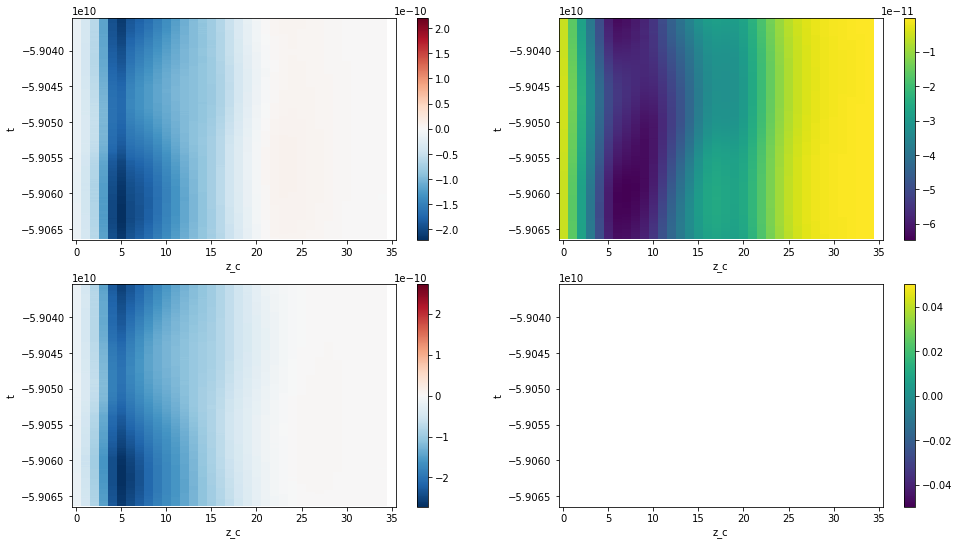

In [34]:
fig,ax = plt.subplots(2,2,figsize=(16,9))
for i, exp in enumerate(ds):
    grid_ops[exp].average(C_h[exp],['Y','X']).plot(ax = ax[i,0])
    grid_ops[exp].average(Ce_h[exp],['Y','X']).plot(ax = ax[i,1])

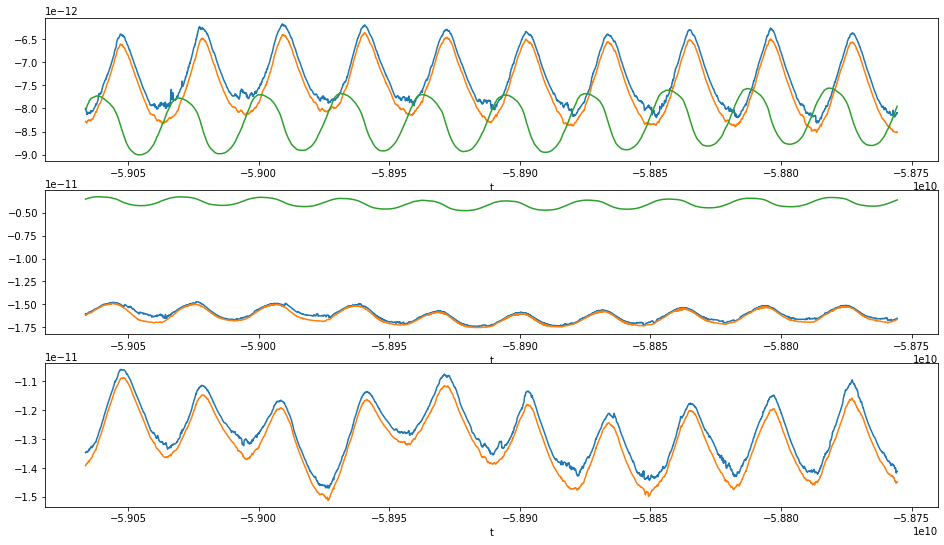

In [82]:
fig,ax = plt.subplots(3,figsize=(16,9))
for i, exp in enumerate(ds):
    Sum_ad[exp].plot(ax = ax[i])
    C_h_replace_m[exp].plot(ax = ax[i])
    Ce_h_m[exp].plot(ax = ax[i])

In [32]:
offset = {exp: Sum_ad[exp]-C_h_m[exp] for exp in ds}
offset_e = {exp: Sum_ad[exp]-C_h_m[exp] for exp in ds}
for exp in ds: print(offset[exp].mean('t').values)
for exp in ds: print(offset_e[exp].mean('t').values)

2.1845400744505759e-13
3.0932541437884553e-13
2.1845400744505759e-13
3.0932541437884553e-13


In [22]:
for exp in ds:
    print((ds[exp].zgDE.diff('t')/(24*60*60) - (Sum[exp]+C_h_m[exp])).mean('t').values)

1.3648278938909236e-13
2.0553778542254729e-13


/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/proj/marine/users/x_bensc/Analysis/myEnv/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


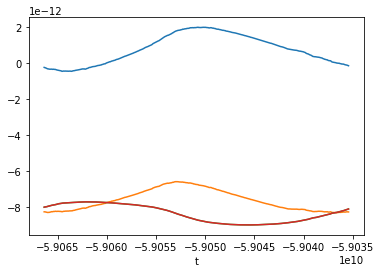

In [37]:
exp0='EXP00_1d10'
properties[exp0].global_mean(C_h[exp0]-Ce_h[exp0]).plot()
properties[exp0].global_mean(C_h[exp0]).plot()
properties[exp0].global_mean(Ce_h[exp0]).plot()
properties[exp0].global_mean(Ce_h_replace[exp0]).plot()

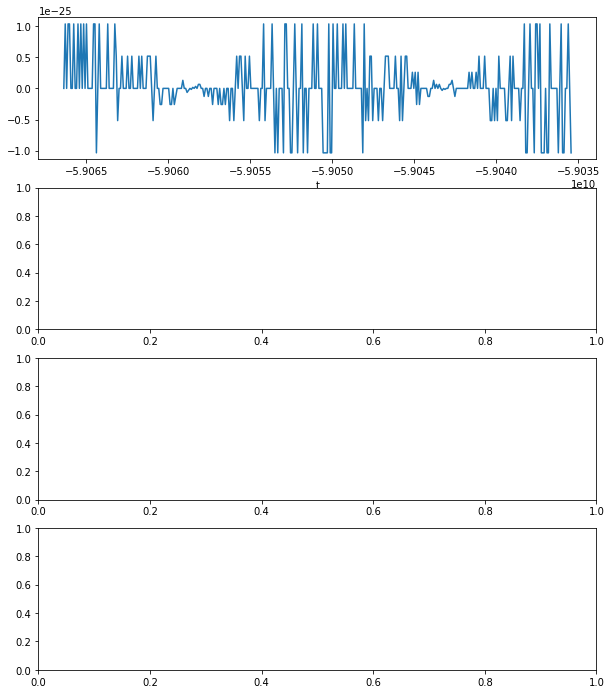

In [54]:
fig, ax = plt.subplots(4, figsize=(10,12))
dt = [24*60*60, 24*60*60, 24*60*60, 24*60*60]
for i, exp in enumerate(ds):
    if i!=0: continue
    (Sum[exp]-(Sums[exp]+Sumt[exp])).plot(ax=ax[i],label=exp)

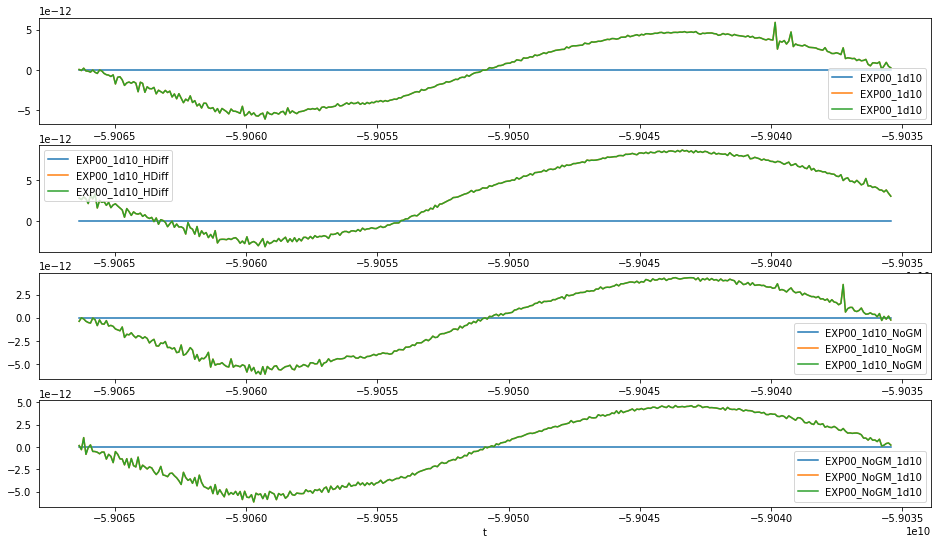

In [38]:
fig, ax = plt.subplots(4, figsize=(16,9))
dt = [24*60*60, 24*60*60, 24*60*60, 24*60*60]
for i, exp in enumerate(ds):
    (Sum[exp]-(Sums[exp]+Sumt[exp])).plot(ax=ax[i],label=exp)
    ((Sums[exp]+Sumt[exp])+C_h_m[exp]-(ds[exp].zgDE.diff('t')/dt[i])).plot(ax=ax[i],label=exp)
    (Sum[exp]+C_h_m[exp]-(ds[exp].zgDE.diff('t')/dt[i])).plot(ax=ax[i],label=exp)
    ax[i].legend()

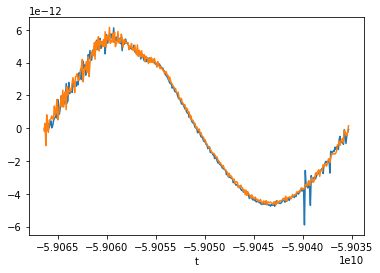

In [19]:
dt = [24*60*60, 24*60*60]
for i, exp in enumerate(ds):
    #(ds[exp].zgDE.diff('t')/dt[i]+Sum_ad[exp] - (Sum[exp]+C_h_m[exp]+Ce_h_m[exp])).isel({'t':slice(0,360)}).plot()
    #(ds[exp].zgDE.diff('t')/dt[i]+Sum_ad[exp] - (Sum[exp]+C_h_m[exp])).isel({'t':slice(0,360)}).plot()
    (ds[exp].zgDE.diff('t')/dt[i] - (Sum[exp]+C_h_m[exp])).plot()

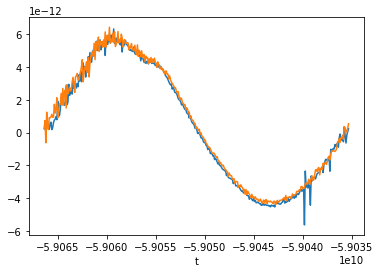

In [21]:
dt = [24*60*60, 24*60*60]
for i, exp in enumerate(ds):
    #(ds[exp].zgDE.diff('t')/dt[i]+Sum_ad[exp] - (Sum[exp]+C_h_m[exp]+Ce_h_m[exp])).isel({'t':slice(0,360)}).plot()
    (ds[exp].zgDE.diff('t')/dt[i]+Sum_ad[exp] - (Sum[exp]+C_h_m[exp]+C_h_m[exp])).isel({'t':slice(0,360)}).plot()
    #(ds[exp].zgDE.diff('t')/dt[i] - (Sum[exp]+C_h_m[exp])).isel({'t':slice(0,360)}).plot()

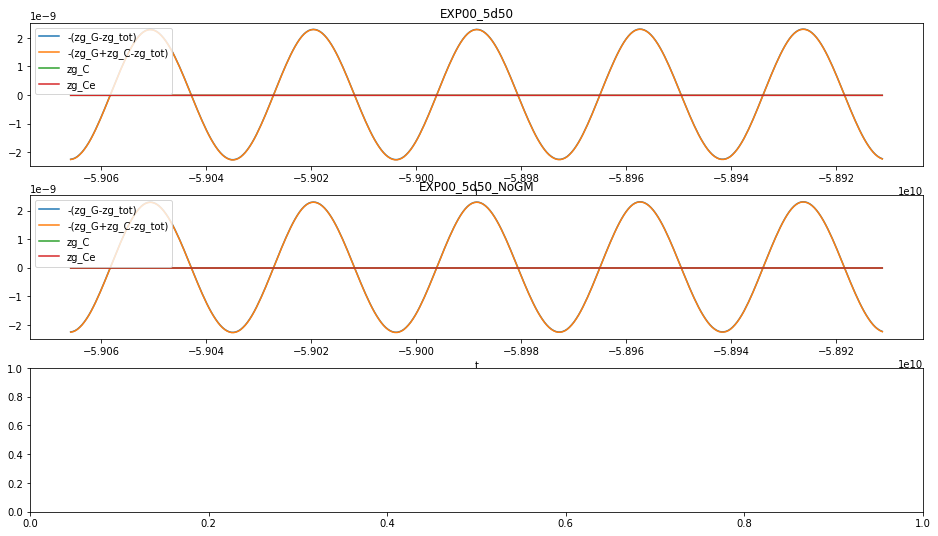

In [11]:
fig, ax = plt.subplots(3, figsize=(16,9))

for i, exp in enumerate(['EXP00_5d50', 'EXP00_5d50_NoGM']):
    ((Sum[exp]-ds[exp].zgDE.diff('t')/(24*60*60))).plot(ax=ax[i],label='-(zg_G-zg_tot)')
    ((Sum[exp]+C_h_m[exp]-ds[exp].zgDE.diff('t')/(24*60*60))).plot(ax=ax[i],label='-(zg_G+zg_C-zg_tot)')
    C_h_m[exp].plot(ax=ax[i],label='zg_C')
    Ce_h_m[exp].plot(ax=ax[i],label='zg_Ce')
    ax[i].set_title(exp)
    ax[i].legend()
    #(C_h_m+Cgm_h_m).plot(ax=ax[0],label='zg_C+zg_Ce')

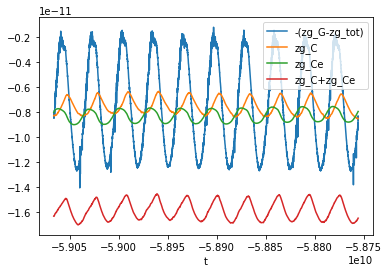

In [11]:
#fig, ax = plt.subplots()
#(ds[exp1].zgDE.diff('t')/(24*60*60)).plot(label='zg_tot')
#(Sum[exp1]).plot(label='zg_G')
(-(Sum[exp0]-ds[exp0].zgDE.diff('t')/(24*60*60))).plot(label='-(zg_G-zg_tot)')
C_h_m.plot(label='zg_C')
Cgm_h_m.plot(label='zg_Ce')
(C_h_m+Cgm_h_m).plot(label='zg_C+zg_Ce')
plt.legend()

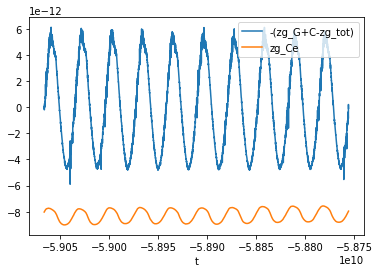

In [12]:
#exp1='EXP00_l_1d10'
#(ds[exp1].zgDE.diff('t')/(24*60*60)).plot(label='zg_tot')
#(-(Sum[exp1]-ds[exp1].zgDE.diff('t')/(24*60*60))).plot(label='-(zg_G-zg_tot)')
(-(Sum[exp0]+C_h_m-ds[exp0].zgDE.diff('t')/(24*60*60))).plot(label='-(zg_G+C-zg_tot)')
#C_h_m.plot(label='zg_C')
Cgm_h_m.plot(label='zg_Ce')
#(C_h_m+Cgm_h_m).plot(label='zg_C+zg_Ce')
plt.legend()

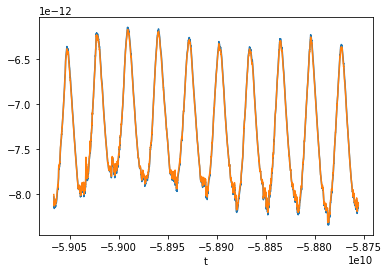

In [21]:
exp0='EXP00_1d10'
#properties[exp0].global_mean(ds[exp0].dzg_Tad, Vmask=ds[exp0].mask_bd_t).plot()
properties[exp0].global_mean(ds[exp0].dzg_Ttotad+ds[exp0].dzg_Stotad, Vmask=ds[exp0].mask_bd_t).plot()
Sum_ad[exp0].plot()

In [1]:
properties[exp1].global_mean(Cgm_h_W[exp1], Vmask=ds[exp1].mask_bd_t).plot()

NameError: name 'properties' is not defined

In [26]:
for exp in ds:
    sum = 0
    for var in dzg_gm[exp]:
        sum+=-dzg_gm[exp][var].mean('t').values/9.81
    print(f'\n{exp}\n--------------')
    print(f'no C: {sum}')
    sum+=properties[exp].global_mean(C_h[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    print(f'+C: {sum}')
    sum+=properties[exp].global_mean(Cgm_h[exp], Vmask=ds[exp].mask_bd_t).mean('t').values
    print(f'+C+Cg: {sum}')


EXP00_l_1d10
--------------
no C: 8.772322426132738e-12
+C: -2.8473411698247826e-12
+C+Cg: -1.1884871332791622e-11

EXP00_l_1d10_NoGM
--------------
no C: 1.0269796928033976e-11
+C: -5.616948432005453e-12
+C+Cg: nan

EXP00_l_1d10_HDiff
--------------
no C: -1.0641639582139613e-11
+C: -1.8322687170181232e-11
+C+Cg: -2.3251154978367122e-11

EXP00_l_1d10_NoGM_HDiff
--------------
no C: -2.16896659384327e-11
+C: -2.9809495037220256e-11
+C+Cg: nan


In [63]:
offset = {exp: Sum_ad[exp]-Ce_h_m[exp] for exp in ds}

In [13]:
dt = [24*60*60,24*60*60, 24*60*60]#6*60*60, 12*60*60, 24*60*60]
zg_tend={}
zg_tend2={}
zg_tend3={}
for i, exp in enumerate(ds):
    zg_tend[exp]=(Sum[exp]+C_h_m[exp]).cumsum('t')*dt[i]
    #zg_tend2[exp]=(Sum[exp]+C_h_m[exp]).cumsum('t')*dt[i]
    zg_tend3[exp]=(Sum[exp]+C_h_m[exp]+Ce_h_m[exp]-Sum_ad[exp]).cumsum('t')*dt[i]
    #zg_tend[exp]=(Sum[exp]*dt[i]+C_h_m[exp]*dt[i]+Ce_h_m[exp]*dt[i]-Sum_ad[exp]*dt[i]).cumsum('t')

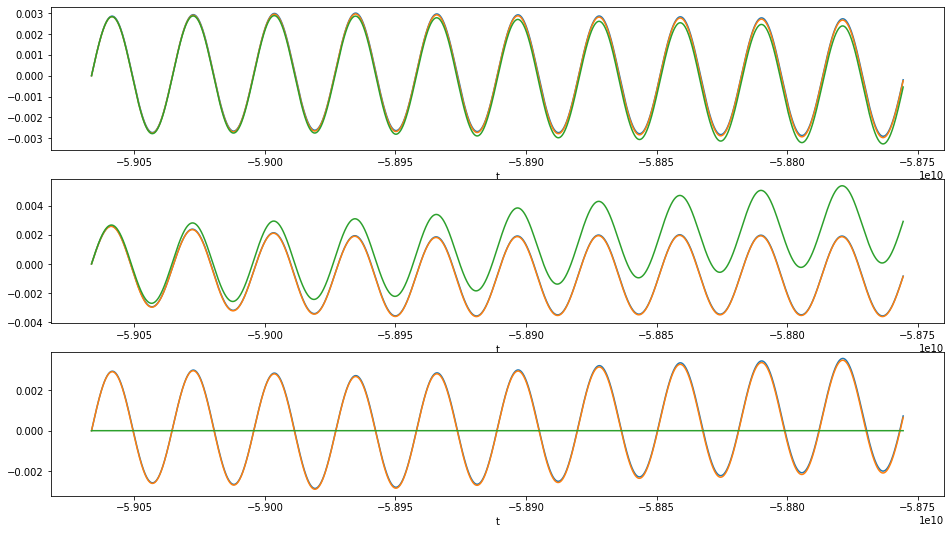

In [14]:
fig,ax=plt.subplots(3,figsize=(16,9))
for i, exp in enumerate(ds):
    (ds[exp].zgDE-ds[exp].zgDE[0]).plot(ax=ax[i])
    zg_tend[exp].plot(ax=ax[i])
    zg_tend3[exp].plot(ax=ax[i])
    #zg_tend3[exp].plot(ax=ax[i])
    